## Age prediction based on images with CNN

Michal Lüley
Peter Mervart

We used tensorflow for our model

Used dataset: https://www.kaggle.com/datasets/mariafrenti/age-prediction

## Used libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, RandomBrightness, RandomContrast, RandomRotation, RandomFlip, Dropout
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pathlib
import wandb
from wandb.keras import WandbCallback
import numpy as np

### Data reduction based on percentage

While developing our model we experimented with different sizes of dataset and concluded the full size was the best.

In [2]:
#percentage = 0.20
#PROJECT_DIR = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), "zadanie2")
#for i in range(1, 101):
#    directory = PROJECT_DIR + '\\photos\\age_prediction_up\\age_prediction\\train\\'
#    directory = directory + str(i).zfill(3) + "\\"
#    pictures_delete = os.listdir(directory)
#    amount = int(len(pictures_delete) * percentage)
#    pictures_delete = pictures_delete[amount:]
#    for file_ in pictures_delete:
#        os.remove(os.path.join(directory, file_))

### Wandb connection

In [3]:
wandb.init()
config = wandb.config

wandb: Currently logged in as: xmervart (nsiete_peto_michal). Use `wandb login --relogin` to force relogin


## Dataset loading

Split data with ratio 90%:10% and then split the 10% into half. So in the end we get 90%:5%:5% = train:validation:test. Set batch size, seed and color (in our case we used grayscale images).

In [ ]:
TRAIN_PHOTOS = os.path.join("C:\\Users\\petoo\\Desktop\\School\\NN\\Zadanie 2\\git\\NSIETE-zadania\\zadanie2\\photos\\age_prediction_up\\age_prediction\\train")

In [5]:
BATCH_SIZE = 64
SEED = 123
VALIDATION_SPLIT = 0.1

config.seed = SEED
config.batch_size = BATCH_SIZE
config.color = "GRAY"

Load images into 2 datasets.

In [6]:
def load_images(mode: str) -> list:
    return tf.keras.utils.image_dataset_from_directory(
                TRAIN_PHOTOS,
                validation_split=VALIDATION_SPLIT,
                subset=mode,
                label_mode='int',
                seed=SEED,
                color_mode="grayscale",
                image_size=(128, 128),
                batch_size=BATCH_SIZE)

In [7]:
X_train, X_valid = load_images("both")


Found 184185 files belonging to 100 classes.
Using 165767 files for training.
Using 18418 files for validation.


Change class names to float because we look at this problem as regression problem.

In [8]:
X_train.class_names = [float(x) for x in X_train.class_names]
X_valid.class_names = [float(x) for x in X_valid.class_names]

Split valid set to valid and test set.

In [9]:
val_batches = tf.data.experimental.cardinality(X_valid)
X_test = X_valid.take((val_batches) // 2)
X_valid = X_valid.skip((val_batches) // 2)

In [10]:
print(tf.data.experimental.cardinality(X_valid) * BATCH_SIZE)
print(tf.data.experimental.cardinality(X_test) * BATCH_SIZE)

tf.Tensor(9216, shape=(), dtype=int64)
tf.Tensor(9216, shape=(), dtype=int64)


## Data cleaning

We removed around 1500 photos by hand (We only removed outliers that were clearly labeled wrong or photos that did not have a person in it). While cleaning the data, we realized there were many photos incorrectly labeled. We found multiple cases of same picture being in multiple ages and so on. We concluded that there were many mistakes made during labeling of the data and it heavily affected accuracy of our model.

## Preprocessing and augmentation

4 preprocessing methods which we tried but were not beneficial in our case.

In [11]:
# Define preprocessing functions
def preprocess(image, label, mode = "brightness"):
    image = tf.cast(image, tf.float32)
    preprocess_function = None

    if mode == "brightness":
        preprocess_function = tf.keras.layers.RandomBrightness(factor=config.random_brightness)
    elif mode == "contrast":
        preprocess_function = tf.keras.layers.RandomContrast(factor=config.random_contrast)
    elif mode == "flip":
        preprocess_function = tf.keras.layers.RandomFlip(mode="horizontal")
    elif mode == "rotation":
        preprocess_function = tf.keras.layers.RandomRotation(factor=config.random_rotation)

    # Applying preprocess function to image
    if preprocess_function is not None:
        image = preprocess_function(image, training=True)

    return image, label

# Apply preprocessing to the dataset using the map() method
#X_train = X_train.concatenate(X_train.map(preprocess))
#X_valid = X_valid.concatenate(X_valid.map(preprocess))

## Insight into the data

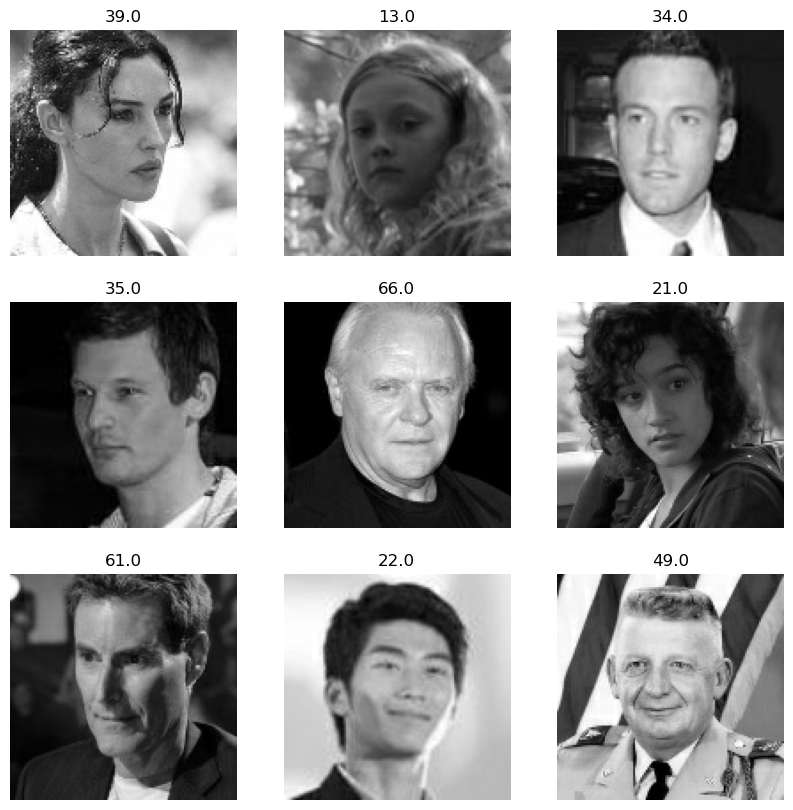

In [12]:
class_names = X_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in X_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize for training

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

X_train = X_train.cache().prefetch(buffer_size=AUTOTUNE)
X_valid = X_valid.cache().prefetch(buffer_size=AUTOTUNE)

## Model set-up

We used early stopping so we set max epochs to 1000. After multiple experiments we end up with learning rate 0.0002 (Higher learning rate caused the model to overfit faster and lower did not learn as much). We used leaky_relu as our activation function and Adam as optimizer (We tried different activation function and optimizers which were not more efficient). Droupout values were adjusted based on experiments (higher values tended to underfit and lower values tended to overfit the model, rising the dropout after CNN was more beneficial). We used batch normalization after every filter to speed up learning (not time wise).

In [15]:
MAX_EPOCHS = 1000

LEARNING_RATE = 0.0002
config.learning_rate = LEARNING_RATE
config.dataPercentageAmount = 100

config.activation = 'leaky_relu'
config.optimizer = 'adam'
config.batchNormalization = "After every filter"

config.random_rotation = 0.0
config.random_flip = 0.0
config.random_contrast = 0.0
config.random_brightness = 0.0

dropout1 = 0.6
dropout2 = 0.3
dropout3 = 0.3

config.dropout1 = dropout1
config.dropout2 = dropout2
config.dropout3 = dropout3

In the beginning of our model we converted grayscale value to float.

Our model consists of 3 convolutional layers with kernel of size 3x3 and same padding to avoid incorrect calculation (odd size of filters). After first filter we used MaxPooling to reduce the size of map and extract more detailed features. We slowly reduced the size of layers to reduce the amount of calculation in MLP part of the model and reduce overfitting. After last filter we also used Dropout to prevent overfitting. We flattened the data and used 2 layers (32 and 16 neurons) and 1 output layer with 1 neuron (linear activation to get 1 float number)

In [16]:
model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='leaky_relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='leaky_relu', padding="same"),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation='leaky_relu', padding="same"),
    BatchNormalization(),
    Dropout(dropout1),
    Flatten(),
    Dense(32, activation='leaky_relu'),
    Dropout(dropout2),
    Dense(16, activation='leaky_relu'),
    Dropout(dropout3),
    Dense(1, activation='linear')
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss=tf.keras.losses.MeanAbsoluteError())

We used Mean Absolute Error as our loss and evaluation metric.

### Create callbacks for early stopping, checkpoint and wandb

In [17]:
def get_callbacks(patience, checkpoint_filepath):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = patience)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    
    wandb = WandbCallback()
    
    return [wandb, es, checkpoint]

## Model training

We used patience of 20 (unfortunately the val loss tended to oscillate so we could not used lower patience)

In [18]:
checkpoint_filepath = "checkpoints/checkpoint_weights"
patience = 20

history = model.fit(X_train, validation_data=X_valid, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
                    callbacks=get_callbacks(patience, checkpoint_filepath))

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/1000
2591/2591 [==============================] - ETA: 0s - loss: 12.1404

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 84s 32ms/step - loss: 12.1404 - val_loss: 10.9521
Epoch 2/1000
2591/2591 [==============================] - 74s 28ms/step - loss: 11.3815 - val_loss: 11.4338
Epoch 3/1000
2591/2591 [==============================] - 74s 28ms/step - loss: 11.1061 - val_loss: 12.2898
Epoch 4/1000
2589/2591 [============================>.] - ETA: 0s - loss: 10.8901

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 72s 28ms/step - loss: 10.8897 - val_loss: 10.2283
Epoch 5/1000
2591/2591 [==============================] - 70s 27ms/step - loss: 10.6859 - val_loss: 10.8852
Epoch 6/1000
2589/2591 [============================>.] - ETA: 0s - loss: 10.5927

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 72s 28ms/step - loss: 10.5928 - val_loss: 8.6796
Epoch 7/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 10.4770 - val_loss: 9.5267
Epoch 8/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 10.3416 - val_loss: 13.9142
Epoch 9/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 10.2809 - val_loss: 14.0917
Epoch 10/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 10.0859 - val_loss: 15.7480
Epoch 11/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 10.0421 - val_loss: 10.5677
Epoch 12/1000
2589/2591 [============================>.] - ETA: 0s - loss: 9.9481

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 75s 29ms/step - loss: 9.9481 - val_loss: 8.3786
Epoch 13/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 9.8920 - val_loss: 9.7811
Epoch 14/1000
2591/2591 [==============================] - 70s 27ms/step - loss: 9.7704 - val_loss: 11.8412
Epoch 15/1000
2591/2591 [==============================] - 70s 27ms/step - loss: 9.7397 - val_loss: 8.5642
Epoch 16/1000
2591/2591 [==============================] - 70s 27ms/step - loss: 9.6679 - val_loss: 9.5069
Epoch 17/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 9.6050 - val_loss: 10.4359
Epoch 18/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 9.5429 - val_loss: 8.7066
Epoch 19/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 9.4801 - val_loss: 11.4388
Epoch 20/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 9.4147 - val_loss: 8.5430
Epoch 21/1000
2591/2591 [=======================

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 73s 28ms/step - loss: 8.9070 - val_loss: 8.1320
Epoch 32/1000
2591/2591 [==============================] - 71s 27ms/step - loss: 8.8769 - val_loss: 8.2141
Epoch 33/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.8415 - val_loss: 8.4474
Epoch 34/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.7885 - val_loss: 10.3959
Epoch 35/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.7385 - val_loss: 9.0962
Epoch 36/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.7023 - val_loss: 8.6336
Epoch 37/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.6458 - val_loss: 8.1905
Epoch 38/1000
2591/2591 [==============================] - 71s 28ms/step - loss: 8.5907 - val_loss: 8.3812
Epoch 39/1000
2591/2591 [==============================] - 70s 27ms/step - loss: 8.5747 - val_loss: 9.7072
Epoch 40/1000
2591/2591 [=========================

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 73s 28ms/step - loss: 8.4722 - val_loss: 8.0211
Epoch 43/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.4133 - val_loss: 8.1468
Epoch 44/1000
2589/2591 [============================>.] - ETA: 0s - loss: 8.3918

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 73s 28ms/step - loss: 8.3915 - val_loss: 7.9610
Epoch 45/1000
2591/2591 [==============================] - 71s 28ms/step - loss: 8.3308 - val_loss: 9.5599
Epoch 46/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.3261 - val_loss: 8.0394
Epoch 47/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.2891 - val_loss: 9.1070
Epoch 48/1000
2591/2591 [==============================] - 71s 28ms/step - loss: 8.2394 - val_loss: 8.0547
Epoch 49/1000
2589/2591 [============================>.] - ETA: 0s - loss: 8.2198

INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\NN\Zadanie 2\git\NSIETE-zadania\zadanie2\wandb\run-20230410_184425-c3wxht53\files\model-best)... Done. 0.0s


2591/2591 [==============================] - 73s 28ms/step - loss: 8.2194 - val_loss: 7.8748
Epoch 50/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.1852 - val_loss: 8.8887
Epoch 51/1000
2591/2591 [==============================] - 72s 28ms/step - loss: 8.1677 - val_loss: 8.2992
Epoch 52/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 8.1324 - val_loss: 9.4772
Epoch 53/1000
2591/2591 [==============================] - 77s 30ms/step - loss: 8.1156 - val_loss: 8.3817
Epoch 54/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 8.1047 - val_loss: 9.8942
Epoch 55/1000
2591/2591 [==============================] - 74s 29ms/step - loss: 8.0680 - val_loss: 8.1268
Epoch 56/1000
2591/2591 [==============================] - 74s 28ms/step - loss: 8.0575 - val_loss: 8.5965
Epoch 57/1000
2591/2591 [==============================] - 73s 28ms/step - loss: 8.0270 - val_loss: 10.9183
Epoch 58/1000
2591/2591 [=========================

In [19]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▄▅▄▂▃█▄▃▅▃▂▂▃▂█▂▂▆▁▄▂▁▃▁▁▁▁▁▁▁▂▁▂▁▃▂▁▂▄▂
best_epoch,48
best_val_loss,7.87481
epoch,68
loss,7.75237
val_loss,8.99206


Load the weights that performed the best on validation set.

In [24]:
model.load_weights(checkpoint_filepath)

### Test set evaluation

We achieved MAE around 7.5 on every set. Our MAE was affected by the difficulty of the problem (age based on looks is hard even for humans) and mislabeled data. Also we predicted on scale 1-100 so the MAE was much higher in higher ages where the difference in looks is less apparent. 

In [25]:
print(model.evaluate(X_test, batch_size=64))

144/144 [==============================] - 2s 11ms/step - loss: 7.8732
7.8732171058654785


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       1

### Prediction example on validation set

1/1 [==============================] - 0s 12ms/step


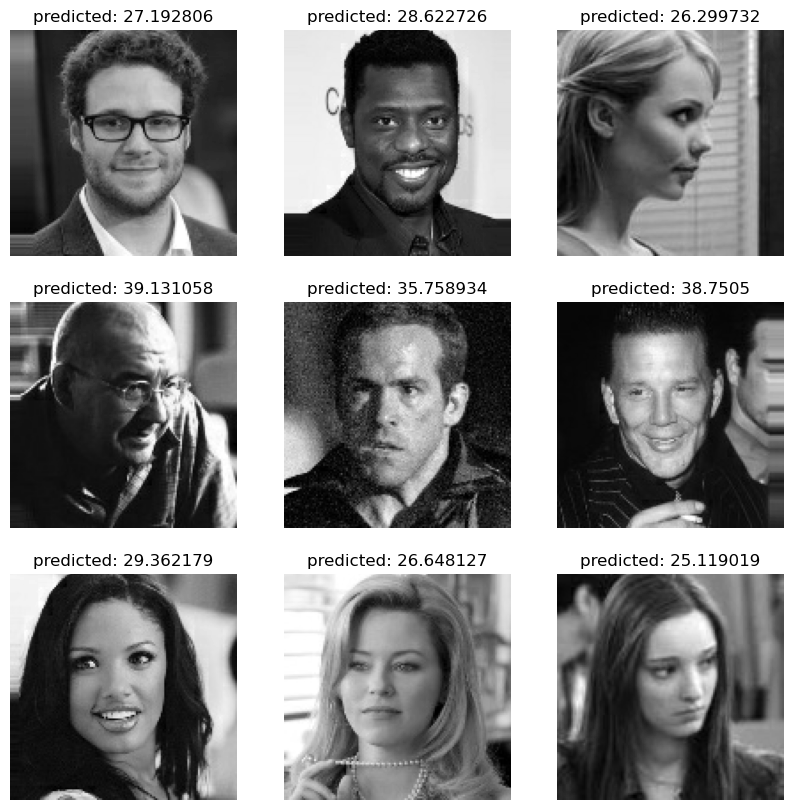

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in X_valid.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    np_image = images[i].numpy()
    np_image = np_image.astype('float32')
    np_image = np.expand_dims(np_image, axis=0)
    prediction = model.predict(np_image)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title("predicted: " + str(prediction[0][0]))
    plt.axis("off")

### Graphs of 2 different runs with same model (loss and validation loss)

Training time around 80 seconds per epoch on RTX 3070

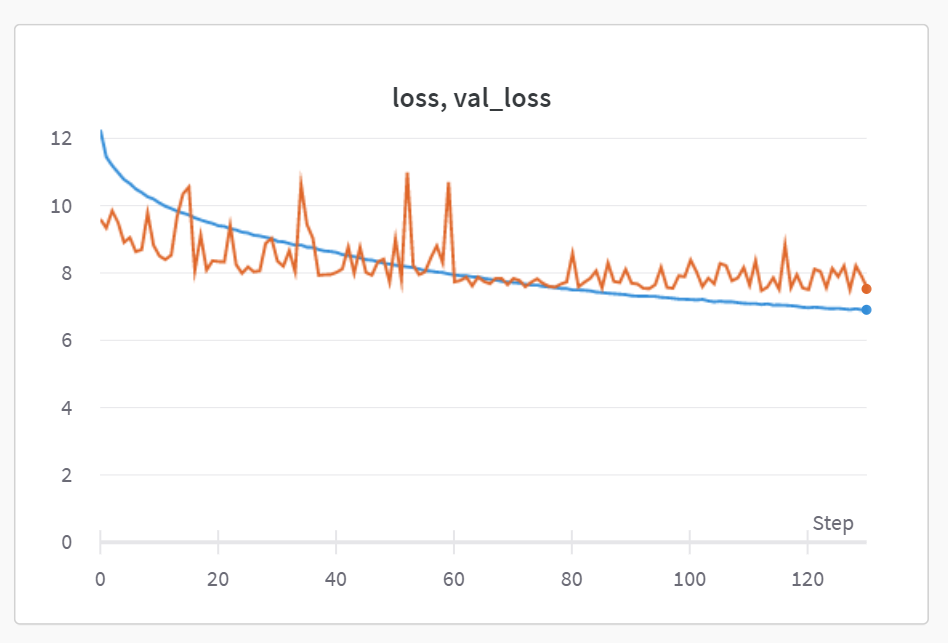

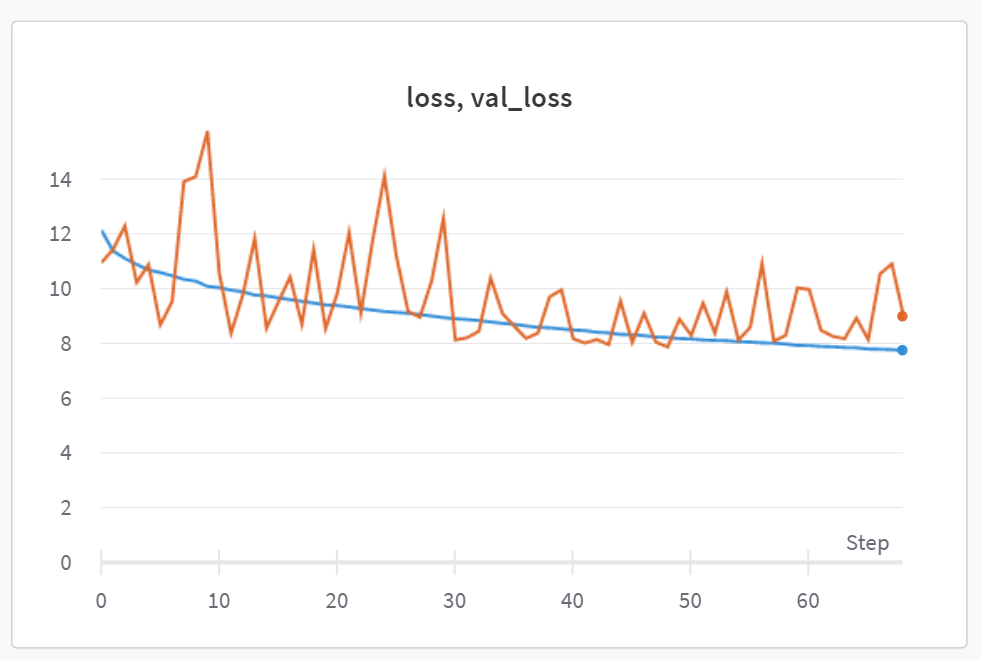